<a href="https://colab.research.google.com/github/Alafiade/Satellite-Image-classification-with-Mobilenet/blob/main/SATELLITE_IMAGE_CLASSIFICATION_USING_MOBILE_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING DEPENDENCIES

In [5]:
!pip install split-folders
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
plt.ion()
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import splitfolders
import torch.utils.data as data

DATA AQUISITION

In [1]:
#Downloading data from Kaggle
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
100% 21.8M/21.8M [00:02<00:00, 20.5MB/s]
100% 21.8M/21.8M [00:02<00:00, 10.9MB/s]


In [2]:
!unzip satellite.zip #Unzipping the data

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

DATA PREPROCESSING

In [3]:
!pip install split-folders # Install splitfolders using pip
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.utils.data as data
import splitfolders # Import splitfolders


# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define data directories
data_dir = "/content/data"  # Replace with the actual path to your data directory
output_dir = "/content/sample_data" # Define output directory for split data

# Split the data into train and val sets using splitfolders
# This will create 'train' and 'val' directories inside output_dir
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.8, 0.2), group_prefix=None)

# Update train_dir and val_dir to point to the newly created directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create ImageFolder datasets
image_datasets = {
    'Training': datasets.ImageFolder(train_dir, transform=transform),
    'Validation': datasets.ImageFolder(val_dir, transform=transform)
}

# Create DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
    for x in ['Training', 'Validation']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Copying files: 5631 files [00:00, 8781.03 files/s]


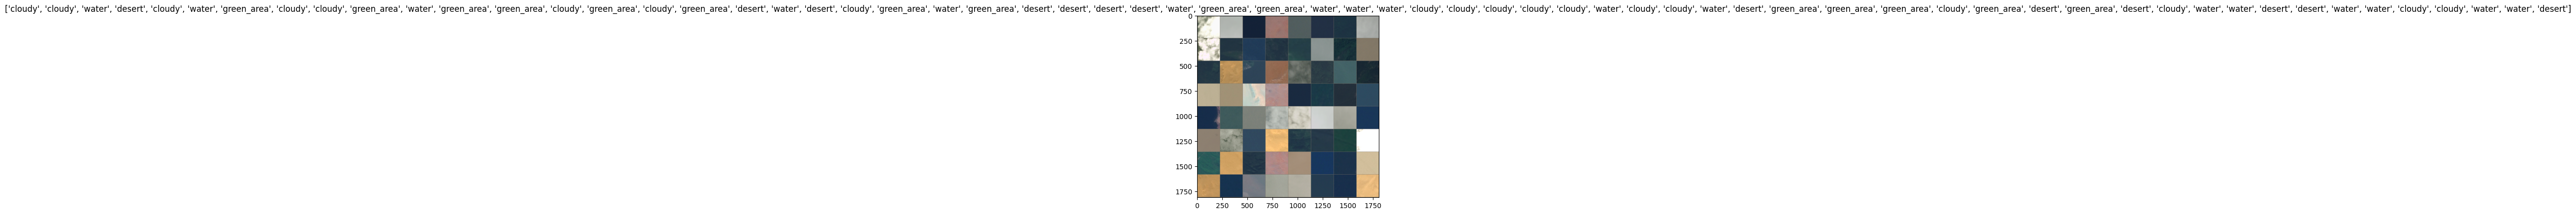

In [6]:
#Displaying Validation Images
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Validation']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

IMPORTING PRETRAINED MOBILE NET V2

In [8]:
width_multiplier = 1.0 #Setting desired width multiplier
#Loading model with weights(setting the weights argument to models.MobileNet_V2_Weights.IMAGENET1K_V1 w
#which tells the function to load the pre-trained weights from ImageNet1K)
mobilenet_v2 = models.mobilenet_v2(weights= models.MobileNet_V2_Weights.IMAGENET1K_V1)
print(mobilenet_v2)
mobilenet_v2.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 83.4MB/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

IMPORTING/OPTIMIZER/ DROPOUT LAYER/CRITERION

In [9]:
import torch.optim as optim
optimizer = optim.SGD(mobilenet_v2.classifier.parameters(),lr=0.001, momentum=0.9, weight_decay=0.01)

In [10]:
torch.nn.Dropout(p=0.3) # Adding dropout layer with the probability 0.3

Dropout(p=0.3, inplace=False)

In [12]:
import  torch.nn as nn
criterion = nn.CrossEntropyLoss()

MODEL TRAINING

In [13]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Move model to device
    mobilenet_v2.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)



                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(mobilenet_v2, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
Training Loss: 2.9932 Acc: 0.4787
Validation Loss: 0.4530 Acc: 0.8385
Epoch 2/20
----------
Training Loss: 0.3919 Acc: 0.8595
Validation Loss: 0.2227 Acc: 0.9201
Epoch 3/20
----------
Training Loss: 0.2747 Acc: 0.9012
Validation Loss: 0.1936 Acc: 0.9397
Epoch 4/20
----------
Training Loss: 0.2474 Acc: 0.9110
Validation Loss: 0.1520 Acc: 0.9485
Epoch 5/20
----------
Training Loss: 0.2109 Acc: 0.9258
Validation Loss: 0.1121 Acc: 0.9707
Epoch 6/20
----------
Training Loss: 0.1753 Acc: 0.9412
Validation Loss: 0.1291 Acc: 0.9610
Epoch 7/20
----------
Training Loss: 0.1667 Acc: 0.9449
Validation Loss: 0.0884 Acc: 0.9787
Epoch 8/20
----------
Training Loss: 0.1443 Acc: 0.9496
Validation Loss: 0.1009 Acc: 0.9716
Epoch 9/20
----------
Training Loss: 0.1407 Acc: 0.9540
Validation Loss: 0.1063 Acc: 0.9663
Epoch 10/20
----------
Training Loss: 0.1369 Acc: 0.9558
Validation Loss: 0.0841 Acc: 0.9769
Epoch 11/20
----------
Training Loss: 0.1361 Acc: 0.9523
Validation Loss: 0.097

TESTING FOR INFERENCE TIME

In [18]:
import torch
torch.cuda.empty_cache()

start_memory = torch.cuda.memory_allocated()

# Move the inputs tensor to the same device as the model
with torch.no_grad():
    _ = model(inputs.to(device))

end_memory = torch.cuda.memory_allocated()

memory_used = (end_memory - start_memory)/ (1024**2)
print(f'Memory used for inferece:{memory_used:.2f}MB')

Memory used for inferece:0.24MB


VISUALIZING TRAINING LOG

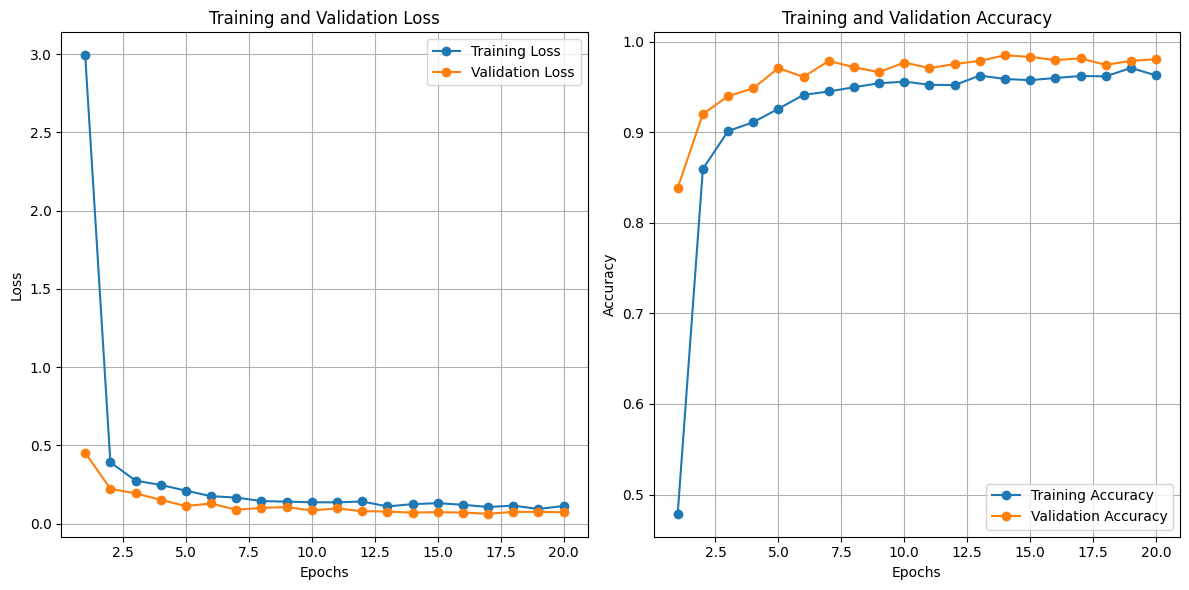

In [19]:
import matplotlib.pyplot as plt

# Data extracted from the training logs
epochs = list(range(1, 21))
training_loss = [2.9932, 0.3919, 0.2747, 0.2474, 0.2109, 0.1753, 0.1667, 0.1443, 0.1407, 0.1369,
                 0.1361, 0.1416, 0.1102, 0.1246, 0.1311, 0.1205, 0.1064, 0.1155, 0.0938, 0.1128]
validation_loss = [0.4530, 0.2227, 0.1936, 0.1520, 0.1121, 0.1291, 0.0884, 0.1009, 0.1063, 0.0841,
                   0.0974, 0.0798, 0.0775, 0.0705, 0.0738, 0.0708, 0.0630, 0.0752, 0.0754, 0.0731]
training_accuracy = [0.4787, 0.8595, 0.9012, 0.9110, 0.9258, 0.9412, 0.9449, 0.9496, 0.9540, 0.9558,
                     0.9523, 0.9520, 0.9625, 0.9587, 0.9574, 0.9598, 0.9620, 0.9616, 0.9709, 0.9627]
validation_accuracy = [0.8385, 0.9201, 0.9397, 0.9485, 0.9707, 0.9610, 0.9787, 0.9716, 0.9663, 0.9769,
                       0.9707, 0.9752, 0.9787, 0.9849, 0.9831, 0.9796, 0.9814, 0.9743, 0.9787, 0.9805]

# Plot Loss Curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
